In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
from IPython.display import display
import os

def github_token_button_clicked(b):
    os.environ["GITHUB_TOKEN"] = "YOUR_GITHUB_TOKEN_HERE"
    print("GitHub Token ortam değişkenine eklendi!")

button1 = widgets.Button(
    description="GitHub Token Ekle",
    button_style='',
    tooltip='GitHub Token Ortam Değişkenine Ekle'
)
button1.on_click(github_token_button_clicked)
display(button1)

Button(description='GitHub Token Ekle', style=ButtonStyle(), tooltip='GitHub Token Ortam Değişkenine Ekle')

GitHub Token ortam değişkenine eklendi!


In [ ]:
#@title GitHub Token Ekle

import ipywidgets as widgets
import os
import datetime
from google.colab import drive
from IPython.display import display

def sync_drive_github(b):
    # Google Drive'ı bağla
    drive.mount('/content/drive', force_remount=True)

    # Git kullanıcı bilgilerini ayarla
    os.system('git config --global user.email "doganzub@gmail.com" > /dev/null 2>&1')
    os.system('git config --global user.name "doganzub" > /dev/null 2>&1')

    # GitHub Token kontrolü
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
    if not GITHUB_TOKEN:
        print("❌ HATA: GitHub Token bulunamadı! Lütfen önce Buton 1 ile ayarlayın.")
        return

    # GitHub repo bağlantısı
    GITHUB_REPO = f"https://{GITHUB_TOKEN}@github.com/doganzub/ml.git"

    # Çalıştırılan notebook'un yolu ve adı (manuel düzenleyin)
    notebook_path = "/content/drive/MyDrive/Colab Notebooks/"
    running_notebook = "3_k_means.ipynb"

    # Repo yoksa klonla
    if not os.path.exists("/content/ml"):
        os.system(f"cd /content && git clone {GITHUB_REPO}")

    # Git dizinine geç
    os.chdir("/content/ml")

    # Branch listesini al
    os.system("git fetch --all")
    existing_branches = os.popen("git branch -r").read()

    filename_parts = running_notebook.split("_")
    if not filename_parts[0].isdigit():
        print(f"🚫 {running_notebook} dosyasının başında rakam yok, işlem iptal edildi!")
    else:
        ders_no = filename_parts[0]
        branch_name = f"ders{ders_no}"

        if f"origin/{branch_name}" not in existing_branches:
            print(f"🚫 {branch_name} branch'i GitHub'da bulunamadı, işlem iptal edildi!")
        else:
            os.system(f"git checkout {branch_name}")
            os.system(f'cp "{notebook_path}{running_notebook}" "/content/ml/"')
            commit_message = f"{running_notebook} güncellendi - {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}"
            os.system("git add .")
            status = os.popen("git status --porcelain").read()

            if status.strip():
                os.system(f'git commit -m "{commit_message}"')
                os.system(f"git push origin {branch_name}")
                print(f"✅ {running_notebook} {branch_name} branch'ine yüklendi!")
            else:
                print(f"⚡ {running_notebook} için değişiklik yok, commit atlanıyor!")
            os.system(f'cp -f "/content/ml/{running_notebook}" "{notebook_path}"')

    print("🎯 GitHub ve Google Drive senkronize edildi!")

# Buton 2: Drive & GitHub Senkronizasyonu
button2 = widgets.Button(
    description="Drive & GitHub Senkronizasyonu",
    button_style='',
    tooltip='Google Drive ve GitHub arasında senkronizasyon yap'
)
button2.on_click(sync_drive_github)
display(button2)

# 🟢 K-Means Kümeleme Analizi – Müşteri Segmentasyonu (Mall Customer Veri Seti)

Bu dokümanda, **Mall Customer Segmentation** veri seti kullanılarak, müşterilerin demografik özellikleri ve alışveriş davranışlarına göre **K-Means Kümeleme Algoritması** ile müşteri segmentasyonu yapılacaktır.  
Hem **teorik bilgiler** hem de **uygulamalı Python kodları** bir arada sunulmuştur.

---

## Çalışma Planı

Bu analiz sürecinde aşağıdaki adımları uygulayacağız:

1. **Gerekli Kütüphanelerin Yüklenmesi**  
2. **Veri Setinin Yüklenmesi ve İncelenmesi**  
3. **Korelasyon Analizi**  
4. **Verilerin Görselleştirilmesi**  
5. **K-Means Kümeleme Algoritmasının Uygulanması**  
6. **Kümeleme Sonuçlarının Görselleştirilmesi**  
7. **Kümeleme Kalitesinin Değerlendirilmesi (Silhouette)**  
8. **En İyi Küme Sayısının Belirlenmesi (Elbow, Silhouette)**

---

## Neden Bu Çalışmayı Yapıyoruz?

Müşteri segmentasyonu, günümüz veri odaklı pazarlama stratejilerinde oldukça önemli bir yere sahiptir.  
Bu analiz ile:

🔸 Müşteri kitlesini **benzer özelliklere sahip alt gruplara** ayırabiliriz.  
🔸 Bu gruplara yönelik **kişiselleştirilmiş kampanyalar** geliştirebiliriz.  
🔸 Müşteri davranışlarını daha iyi anlayarak **iş stratejilerini** optimize edebiliriz.

**K-Means Algoritması**, benzerlik temelli gruplama yapılmasını sağlayan en popüler **denetimsiz öğrenme yöntemlerinden** biridir.

---

## 📄 Mall Customer Segmentation Veri Seti Hakkında

Bu çalışmada kullanacağımız veri seti, bir alışveriş merkezine gelen müşterilere ait demografik bilgileri ve harcama skorlarını içermektedir.

### 🟢 Veri setinin temel özellikleri:

| Sütun Adı         | Açıklama                                           |
|-------------------|----------------------------------------------------|
| CustomerID       | Müşteri numarası                                    |
| Gender           | Cinsiyet bilgisi                                    |
| Age              | Müşterinin yaşı                                     |
| Annual Income (k)| Müşterinin yıllık geliri (1000$ cinsinden)         |
| Spending Score (1-100) | Müşterinin harcama skoru (1 ile 100 arasında) |

---

## 🌐 Veri Setinin Kaynağı

Veri seti, **Kaggle** üzerinden ücretsiz olarak paylaşılmıştır:

🔗 [Mall Customer Segmentation Dataset – Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

**Bu çalışma için veri seti önceden indirilmiş ve Google Drive'a yüklenmiştir.**  
Dosya yolu aşağıdaki gibidir:

📄 `/content/drive/MyDrive/ColabNotebooks/mall_customers.csv`

---

## 🔍 Bu Çalışmada Neler Öğreneceğiz?

✅ Gerçek dünya verisinin yapısını incelemeyi  
✅ Veri temizleme ve ön işlem adımlarını uygulamayı  
✅ Müşteri özelliklerine dayalı segmentler oluşturmayı  
✅ K-Means algoritması ile kümeleme modelini kurmayı  
✅ Kümeleme sonuçlarını yorumlamayı  
✅ Küme sayısını belirlemek için **Elbow Yöntemi** ve **Silhouette Skoru** kullanmayı öğreneceğiz.

---

## ⭐️ Çalışmanın Hedefi

Bu çalışma sonunda:

✔️ Müşteri segmentasyonu sürecini baştan sona uygulayabileceksiniz.  
✔️ K-Means algoritmasını gerçek veri üzerinde uygulama deneyimi kazanacaksınız.  
✔️ Elde edilen segmentleri pazarlama stratejilerinde nasıl kullanabileceğinizi anlayacaksınız.

---


## 1️⃣ Gerekli Kütüphaneler

In [ ]:
#  Gerekli Kütüphaneleri yüklüyoruz

import numpy as np                # Sayısal işlemler için kullanılır
import pandas as pd               # Veri okuma ve düzenleme için kullanılır
import seaborn as sns             # Grafikler ve görselleştirme için kullanılır
import matplotlib.pyplot as plt   # Grafik çizimi için kullanılır

from sklearn.cluster import KMeans                     # K-Means algoritmasını uygulamak için
from sklearn.metrics import silhouette_score           # Kümeleme kalitesini ölçmek için
from yellowbrick.cluster import SilhouetteVisualizer   # Silhouette skorunu görselleştirmek için

import warnings                                            # Uyarı mesajlarını kapatmak için
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize': (8, 5)})                    # Grafik boyut ve stil ayarı

print("✅ Gerekli kütüphaneler başarıyla yüklendi.")

✅ Gerekli kütüphaneler başarıyla yüklendi.




---



---



---



## 2️⃣ Veri Setinin Yüklenmesi ve İncelenmesi

---

Bu bölümde, **Google Drive** üzerinde kayıtlı olan **Mall Customers** veri setini yükleyip, veri setinin yapısını inceleyeceğiz.  
Veri setini **pandas DataFrame** formatına dönüştürerek analizlerimize hazırlayacağız.

---

### 🛍️ Mall Customers Veri Seti Nedir?

**Mall Customers** veri seti, bir alışveriş merkezinin müşterilerine ait **demografik bilgiler** ve **harcama davranışı verilerini** içermektedir.

Bu veri seti, özellikle:

- **Müşteri Segmentasyonu**
- **Pazarlama Analitiği**
- **Müşteri Davranış Analizi**
- **K-Means Kümeleme** gibi gözetimsiz öğrenme yöntemleri için sıklıkla kullanılmaktadır.

#### 🟢 Veri Setinin Temel Özellikleri

| Sütun Adı                | Açıklama                                                      |
|-------------------------|---------------------------------------------------------------|
| CustomerID              | Müşteri kimlik numarası                                        |
| Gender                  | Müşteri cinsiyeti (Male / Female)                             |
| Age                     | Müşteri yaşı                                                  |
| Annual Income (k)      | Müşterinin yıllık geliri (bin $ cinsinden)                    |
| Spending Score (1-100)  | Müşterinin harcama skoru (Alışveriş alışkanlığı puanı)        |

---

### 🌐 Veri Setinin Kaynağı

Bu veri seti, **Kaggle** üzerinden ücretsiz olarak erişilebilir:

🔗 [Mall Customers Dataset – Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

Bu çalışmada veri setini önceden indirip **Google Drive**'a yükledik:

📄 **Dosya Yolu:**  
`/content/drive/MyDrive/ColabNotebooks/mall_customers.csv`

---

### 🔍 Bu Adımda Neler Yapacağız?

✅ Google Drive hesabımızı Colab ortamına bağlayacağız.  
✅ Mall Customers veri setini **pandas** kütüphanesi ile **CSV formatından** okuyacağız.  
✅ Veri setinin ilk 5 satırını görüntüleyeceğiz.  
✅ Veri setinin yapısını (satır/sütun sayısı, veri tipleri, eksik değerler) inceleyeceğiz.

---

### ⭐️ Neden Önemlidir?

Veri analizi sürecinin ilk adımı olan **veri setini yükleme ve ön inceleme** aşaması sayesinde:

- Veri setinin genel yapısı hakkında fikir sahibi oluruz.
- Eksik değerleri tespit ederiz.
- Analiz için hangi değişkenleri kullanacağımızı belirleriz.
- Gerekirse ön işleme adımları için hazırlık yaparız.

Bu adım, veri temizliği, segmentasyon ve kümeleme analizlerine geçmeden önce **veri setini tanımak** için kritik öneme sahiptir.


In [ ]:
# 📥 1. Google Drive'ı Colab ortamına bağlıyoruz
from google.colab import drive
drive.mount('/content/drive')

# 📂 2. Pandas kütüphanesi ile veri setini yüklüyoruz
import pandas as pd

# ✅ Dosya yolu
dosya_yolu = '/content/drive/MyDrive/Colab Notebooks/mall_customers.csv'

# 🟢 3. CSV dosyasını DataFrame formatında okuyoruz
df = pd.read_csv(dosya_yolu)

# 🔍 4. Veri setinin ilk 5 satırını görüntülüyoruz
print("Veri setinin ilk 5 satırı:")
display(df.head())

# 📊 5. Veri setinin yapısını inceliyoruz
print("\nVeri setinin yapısı:")
df.info()

# 📏 6. Eksik değer kontrolü yapıyoruz
print("\nEksik Değer Sayısı (Sütun Bazında):")
print(df.isnull().sum())


# 🧹 6. Aykırı değer bilgisi ve eksik veri kontrolü yapılıyor
print("📌 Aykırı Değer Bilgisi:\n", df['Annual Income (k$)'].describe())

print("\n📌 Eksik Veri Kontrolü (Sütun Bazında):")
print(df.isnull().sum())



# 7. Değişkenler arası Pearson korelasyon katsayısı hesaplanıyor
from scipy.stats import pearsonr

corr, p_value = pearsonr(df['Annual Income (k$)'], df['Spending Score (1-100)'])
print(f"📈 Pearson Korelasyon Katsayısı: {corr:.4f}, p-değeri: {p_value:.4f}")




Mounted at /content/drive
Veri setinin ilk 5 satırı:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Veri setinin yapısı:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Eksik Değer Sayısı (Sütun Bazında):
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
📌 Aykırı Değer Bilgisi:
 count    200.000000
mean      60.560000
std       26.264721
min       15.000000
25%       41.500000
50%       61.500000
75%       78.000000
max      137.000000
Name: Annual Income (k$), dtype: float64

📌 Eksik Veri Kontrolü (Sütun Bazında):
Cust



---



---



---



## 3️⃣ Korelasyon Analizi ve Isı Haritası

---

### Neden Korelasyon Analizi Yapılır?

Veri setinde birden fazla sayısal değişken bulunduğunda, bu değişkenler arasında nasıl bir ilişki olduğunu bilmek önemlidir.  
**Korelasyon Analizi**, iki sayısal değişken arasındaki ilişkinin yönünü (**pozitif/negatif**) ve gücünü gösteren bir yöntemdir.

**Korelasyon Katsayısı**:
- **+1** → İki değişken arasında **pozitif ve güçlü bir ilişki** vardır.
- **0** → İki değişken arasında **herhangi bir ilişki yoktur**.
- **-1** → İki değişken arasında **negatif ve güçlü bir ilişki** vardır.

---

### ⭐️ Bu bölümde ne yapıyoruz?

🔸 **Pandas** kütüphanesinin `corr()` fonksiyonu ile **Mall Customers** veri setinde bulunan sayısal değişkenlerin **korelasyon katsayılarını** hesaplıyoruz.

🔸 Hesapladığımız korelasyon katsayılarını **matris** formatında görselleştiriyoruz.

🔸 **Seaborn** kütüphanesinin **heatmap (ısı haritası)** fonksiyonu ile bu ilişkiyi daha anlaşılır şekilde sunuyoruz.  
Isı haritasındaki renkler, korelasyon değerinin büyüklüğünü kolayca görmemizi sağlar.

---

### 📄 Teknik Bilgi

**df.corr() fonksiyonu:**
- Pandas kütüphanesinde yer alır.
- Sayısal değişkenler arasındaki korelasyon katsayısını hesaplar.
- Sadece sayısal sütunlar üzerinde çalışır.

**sns.heatmap() fonksiyonu:**
- Seaborn kütüphanesinde yer alır.
- Korelasyon matrisini renkler ile görselleştirir.
- Parametreler:
  - `annot=True` → Hücreler içine korelasyon katsayısı yazılır.
  - `square=True` → Hücreler kare şeklinde olur.
  - `cmap='flare'` → Renk skalası (istenilen renk paleti seçilebilir).

---

### Neden Önemli?

Korelasyon analizi ile:

✅ Değişkenler arasında **doğrudan veya dolaylı ilişki olup olmadığını** tespit ederiz.  
✅ **Kümeleme, regresyon, sınıflandırma gibi modeller** kurmadan önce değişkenler arasındaki ilişkiyi anlama imkânı sağlar.  
✅ Gereksiz veya çok benzer değişkenleri belirleyerek **özellik seçiminde** faydalı olur.

---



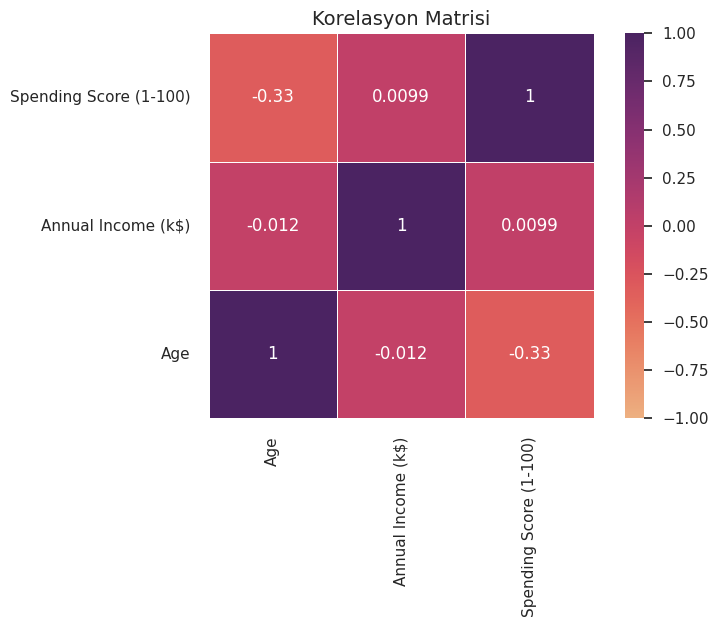

In [12]:
# 📊 Sadece sayısal sütunları al, CustomerID'yi hariç tut
my_cors = df.select_dtypes(include='number').drop(columns='CustomerID').corr()

# 🌡️ Korelasyon matrisi çizimi
sns.heatmap(my_cors, annot=True, cmap="flare", square=True,
            linewidths=0.5, linecolor="white", vmin=-1, vmax=1)

# 🔠 Başlık ve eksen ayarı
plt.title("Korelasyon Matrisi", fontsize=14)
plt.gca().invert_yaxis()
plt.show()


---

### Grafik Analizi

Isı haritasına göre elde edilen korelasyon sonuçları şunlardır:

| Değişken Çifti | Korelasyon Katsayısı | İlişki Türü | Açıklama |
|---------------|:--------------------:|:-----------:|----------|
| **Age & Annual Income** | **-0.01** | ❌ Yok/Zayıf | Bu sonuç, müşterilerin yaşı ile yıllık gelirleri arasında anlamlı bir ilişki olmadığını göstermektedir. Genç veya yaşlı olmak, geliri belirlemiyor.|
| **Age & Spending Score** | **-0.33** | 🔸 Zayıf Negatif | Bu sonuç, yaş arttıkça müşterilerin harcama skorlarının biraz azaldığını gösteriyor. Genç müşteriler harcama konusunda daha aktif olabilir.|
| **Annual Income & Spending Score** | **0.01** | ❌ Yok/Zayıf | Bu sonuç, müşterinin geliri ile harcama skoru arasında anlamlı bir ilişki olmadığını gösterir. Yüksek gelirli olmak, yüksek harcama yapacağını garantilemiyor.|

---

### 🚩 Sonuç olarak bu bilgiler bize ne söyler?

- Bu üç değişken (**Yaş**, **Yıllık Gelir**, **Harcama Skoru**) birbiriyle çok düşük korelasyona sahip.
- Bu da değişkenlerin **birbirini tekrar etmediğini** ve bağımsız bilgiler sunduğunu gösterir.
- Bu durum, **K-Means** kümeleme için olumlu bir durumdur. Çünkü birbirinden bağımsız bilgiler sağlayan bu özelliklerle oluşturacağımız müşteri segmentleri daha net ayrılacaktır.





---


---


---



## 📈 4️⃣ Veri Görselleştirme (Scatter Plot)

Bu bölümde, seçtiğimiz değişken çiftleri arasındaki ilişkileri görsel olarak inceliyoruz.

### 📌 Grafiklerden Neyi Anlamalıyız?

Aşağıdaki grafiklerle değişkenler arasındaki ilişkiyi daha açık hale getiriyoruz:

- **Yaş ile Harcama Skoru** arasındaki grafik, yaş arttıkça harcama skorunun genelde hafif azaldığını gösteriyor (zayıf negatif ilişki).
- **Yıllık Gelir ile Harcama Skoru** arasında belirgin bir ilişki yoktur. Bu, müşterilerin gelirlerinin tek başına harcama skorlarını belirleyemediğini gösteriyor.

Bu grafikler sayesinde, müşteri grupları (segmentleri) oluşturmak için hangi değişkenlerin anlamlı olduğunu ve nasıl dağıldığını anlayacağız.





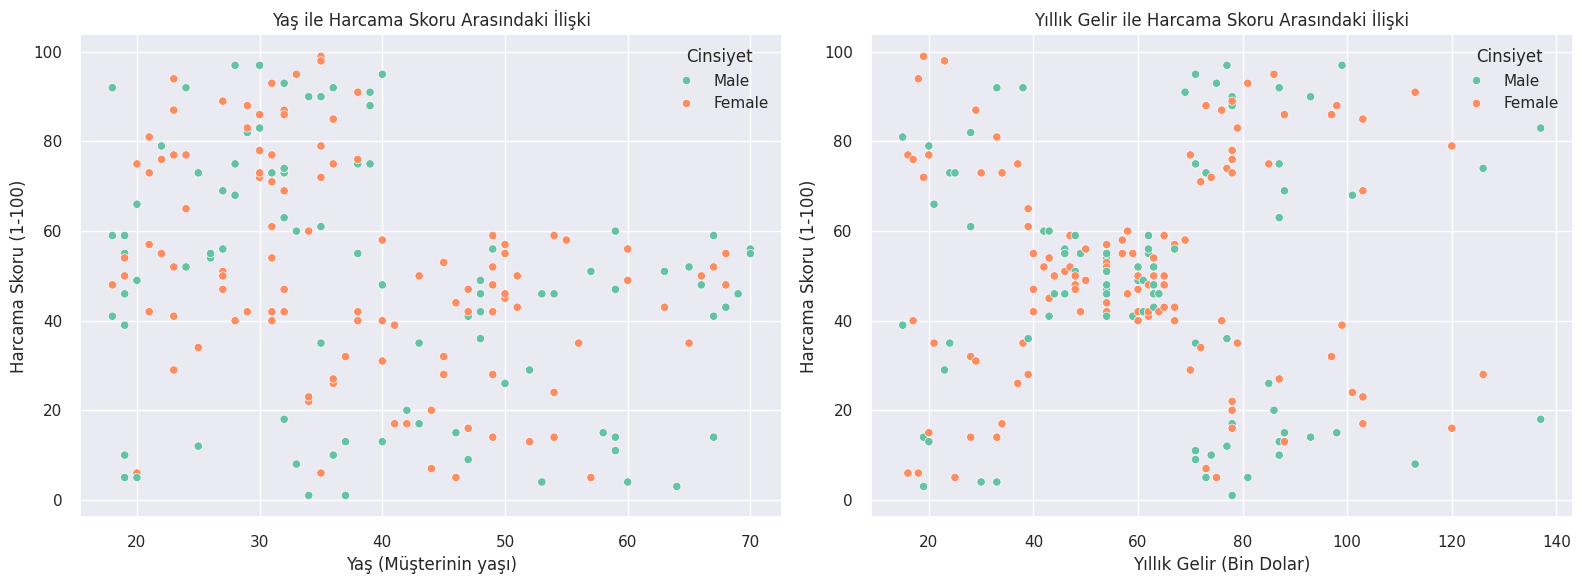

In [ ]:
# Scatter plot için matplotlib ve seaborn kullanıyoruz
plt.figure(figsize=(16,6))

# 🔸 Yaş vs Harcama Skoru Grafiği
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)', hue='Gender', palette='Set2')
plt.title("Yaş ile Harcama Skoru Arasındaki İlişki")
plt.xlabel("Yaş (Müşterinin yaşı)")
plt.ylabel("Harcama Skoru (1-100)")
plt.legend(title="Cinsiyet")

# 🔸 Yıllık Gelir vs Harcama Skoru Grafiği
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', palette='Set2')
plt.title("Yıllık Gelir ile Harcama Skoru Arasındaki İlişki")
plt.xlabel("Yıllık Gelir (Bin Dolar)")
plt.ylabel("Harcama Skoru (1-100)")
plt.legend(title="Cinsiyet")

# Grafiklerin daha iyi yerleşimi için
plt.tight_layout()
plt.show()


## Grafik Analizi

Yukarıdaki iki **scatter plot** grafiği ile müşterilerin farklı özellikleri arasındaki ilişkileri görsel olarak analiz ettik. Bu analiz, müşteri segmentasyonu yaparken hangi değişkenlerin daha anlamlı olduğunu anlamamıza yardımcı olacaktır.

### 🔸 **Yaş ile Harcama Skoru İlişkisi**

- Grafik, müşterinin yaşı arttıkça harcama skorunun genelde azaldığını gösteriyor.
- Özellikle **20-40 yaş arası** müşterilerin harcama skorları daha yüksektir. Bu grup, **yüksek potansiyelli müşteri segmentini** oluşturabilir.
- **40 yaş ve üzeri müşteriler** daha düşük harcama skorlarına sahiptir. Bu grup, farklı bir müşteri segmentini temsil edebilir.
- Grafik üzerinde cinsiyet ayrımına baktığımızda, erkek ve kadın müşterilerin dağılımının benzer olduğunu, belirgin bir cinsiyet farklılığının olmadığını söyleyebiliriz.

### 🔸 **Yıllık Gelir ile Harcama Skoru İlişkisi**

- Bu grafik, yıllık gelir ile harcama skorları arasında net ve güçlü bir ilişki olmadığını gösteriyor.
- Bazı müşterilerin yıllık gelirleri yüksek olmasına rağmen harcama skorları düşük, bazılarının ise tam tersidir. Bu durum, gelir seviyesinin tek başına harcama alışkanlıklarını açıklamadığını belirtir.
- **Dikkat çekici nokta:** Geliri orta düzeyde olan müşterilerin harcama skorları farklılık gösteriyor. Bu da segmentleri belirlerken gelirin yanında başka faktörleri de dikkate almamız gerektiğini işaret ediyor.
- Burada da cinsiyet açısından belirgin bir ayrım olmadığını görüyoruz.

---

###  **Sonuç olarak bu grafiklerle ne elde ettik?**

Bu grafikler bize hangi değişkenlerin segmentasyonu daha iyi yapabileceği hakkında önemli bilgiler verdi:

✅ **Yaş**, segmentasyon için değerli bir değişkendir çünkü harcama skoruyla arasında daha net bir ilişki gözlemledik.

✅ **Yıllık Gelir** ise tek başına yeterli değildir; segmentasyon yaparken başka özelliklerle bir arada kullanılmalıdır.

✅ **Cinsiyet** ise harcama davranışını belirleyici bir faktör değildir. Segmentasyon açısından etkisi sınırlı kalmıştır.




---

---



---



## 5️⃣ K-Means Kümeleme Algoritmasının Uygulanması

Bu bölümde, müşteri segmentasyonu yapmak için **K-Means algoritmasını** uygulayacağız. Bu yöntem, müşterileri benzer özelliklerine göre otomatik olarak gruplandırır.

---

###  K-Means Algoritması Nedir?

**K-Means**, verileri belirli sayıda (**k adet**) kümeye ayıran, popüler bir **denetimsiz öğrenme (unsupervised learning)** algoritmasıdır. Algoritmanın temel hedefi, gruplar içindeki benzerlikleri maksimum, gruplar arasındaki benzerlikleri ise minimum hale getirmektir.

---

###  K-Means Algoritması Nasıl Çalışır?

1. Başlangıçta rastgele olarak **k adet küme merkezi** belirlenir.
2. Her veri noktası, en yakın küme merkezine atanır.
3. Her küme için yeni merkezler (ortalama değerler) tekrar hesaplanır.
4. Bu süreç, küme merkezleri sabitlenene kadar devam eder.

---

###  Bu bölümde neler yapacağız?

- **sklearn** kütüphanesi ile K-Means modelini oluşturacağız.
- Müşterileri "Yıllık Gelir" ve "Harcama Skoru" özelliklerine göre **5 segmente** ayıracağız.
- Segmentasyon sonuçlarını, veri setimize yeni bir sütun olarak ekleyip analizlere hazır hale getireceğiz.

> 🔔 **Not:**  
> Segment sayısını (**k değerini**) belirlerken genellikle birkaç farklı küme sayısı denenir. Bu örnekte başlangıç olarak **5 küme** seçiyoruz. Sonraki adımda (Bölüm 8), küme sayısını optimize etmek için **Elbow** ve **Silhouette** yöntemlerini kullanarak ideal küme sayısını belirleyeceğiz.

---

###  Bu Aşamanın Önemi Nedir?

- Müşterileri benzer satın alma davranışlarına göre otomatik olarak gruplayarak müşterileri daha iyi anlarız.
- Farklı müşteri segmentleri için pazarlama stratejileri geliştirmek daha kolay hale gelir.
- İdeal küme sayısını sonraki aşamalarda daha net belirleyerek, segmentasyon sonuçlarını iyileştirebiliriz.

---


In [ ]:
# K-Means algoritması için gerekli kütüphaneyi içe aktarıyoruz
from sklearn.cluster import KMeans

# 🔸 Kümeleme için kullanacağımız değişkenleri seçiyoruz.
# Burada, "Annual Income (k$)" ve "Spending Score (1-100)" değişkenlerini kullanacağız.
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# 🟢K-Means modelini oluşturuyoruz (5 küme kullanıyoruz).
kmeans = KMeans(n_clusters=5, random_state=42)

# 🟢Modeli eğitiyoruz ve kümeleri oluşturuyoruz.
# Bu adımda müşteriler, benzer özelliklerine göre kümelere atanır.
kmeans.fit(X)

# Her müşterinin küme numarasını DataFrame'e ekliyoruz.
df['Cluster'] = kmeans.labels_

# Sonuçları hızlıca görmek için DataFrame'in ilk 5 satırını yazdırıyoruz.
df.head()



,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4




---



---



---



#  6️⃣ Kümeleme Sonuçlarının Görselleştirilmesi

Bu adımda, **K-Means** algoritmasıyla elde ettiğimiz müşteri segmentlerini net olarak görmek için oluşturduğumuz kümeleri grafik üzerinde görselleştireceğiz.

---

##  Görselleştirmenin Önemi:

Kümeleri görsel olarak incelemek, algoritmamızın müşterileri ne kadar iyi grupladığını anlamak açısından önemlidir. Bu sayede:

- Kümelerin birbirlerinden ayrılıp ayrılmadığını gözlemleyebiliriz.
- Benzer özelliklere sahip müşterilerin gerçekten yakın kümelere yerleşip yerleşmediğini kontrol edebiliriz.
- Segmentlerin ne kadar iyi ayrıştığını görerek, model kalitesini değerlendirebiliriz.

---

## 🔧 Bu Adımda Neler Yapacağız?

- **scatter plot (dağılım grafiği)** ile oluşturduğumuz her kümeyi farklı bir renkle göstereceğiz.
- Küme merkezlerini (**centroids**) belirgin şekilde gösterip, kümelerin merkezlerini net şekilde vurgulayacağız.
- Grafik üzerinde eksenler ve açıklayıcı etiketler ekleyerek anlaşılır bir görsel oluşturacağız.

---


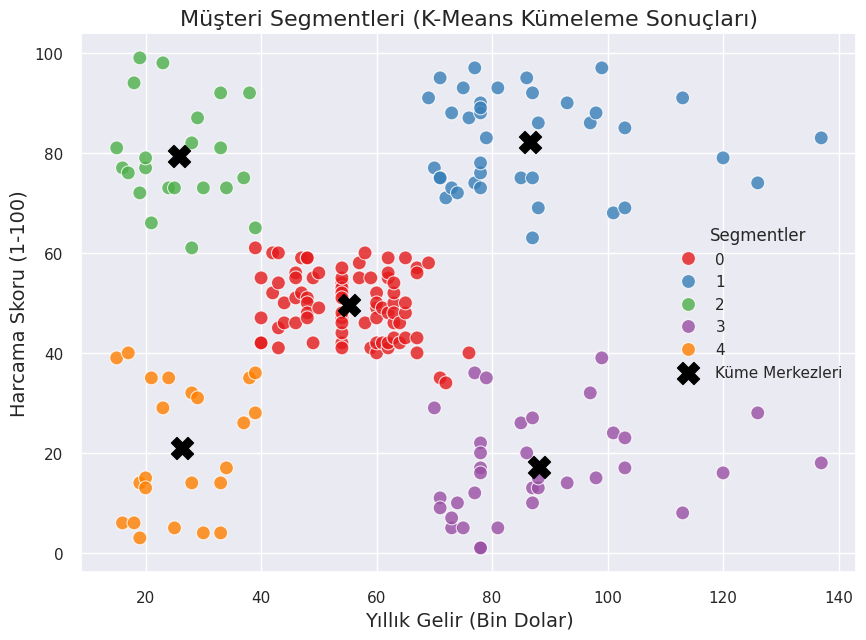

In [ ]:
# Grafik boyutunu belirliyoruz
plt.figure(figsize=(10, 7))

# Her kümeyi farklı renklerde scatter plot ile gösteriyoruz
sns.scatterplot(
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",            # Kümelere göre renkleri ayır
    palette="Set1",           # Renk paleti seçimi
    data=df,                  # Kullanılan veri seti
    s=100,                    # Noktaların boyutu
    alpha=0.8                 # Nokta şeffaflığı
)

# Küme merkezlerini (centroid) çizdiriyoruz
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='black',                # Siyah renk ile merkezleri göster
    s=250,                    # Küme merkezlerinin boyutunu büyük yap
    marker="X",               # Küme merkezleri için belirgin işaret
    label="Küme Merkezleri"
)

# Grafik başlığı ve eksen etiketleri
plt.title("Müşteri Segmentleri (K-Means Kümeleme Sonuçları)", fontsize=16)
plt.xlabel("Yıllık Gelir (Bin Dolar)", fontsize=14)
plt.ylabel("Harcama Skoru (1-100)", fontsize=14)

# Grafik üzerindeki açıklamayı (legend) göster
plt.legend(title="Segmentler")

# Grafiği görüntüle
plt.show()

## 📈 Grafik Analizi: Müşteri Segmentleri (K-Means Kümeleme Sonuçları)

Yukarıdaki grafik, müşterilerin **Yıllık Gelirleri** ile **Harcama Skorları** dikkate alınarak oluşturulmuş **5 farklı müşteri segmentini** göstermektedir.

### Grafik Üzerindeki Önemli Noktalar:
- **Renkli noktalar:** Her nokta, veri setindeki tek bir müşteriyi temsil eder.
- **Renkler (Segmentler):** K-Means algoritmasının belirlediği 5 farklı kümeyi ifade eder. Her renk farklı bir müşteri segmentidir.
- **Siyah X işaretleri:** Küme merkezlerini (**centroid**) gösterir. Bunlar, her segmentteki müşterilerin ortalama gelir ve harcama değerleridir.

### Grafik Bize Neler Söylüyor?
- Grafik üzerinde, kümeler birbirinden **net ve anlamlı şekilde ayrılmış** durumdadır.
- Her küme merkezinin etrafında, ona yakın müşteriler net bir şekilde gruplanmıştır.
- Örneğin:
  - **Mavi segment:** Yüksek gelirli ve yüksek harcama skoruna sahip müşterileri içerir. Bu segment, pazarlama stratejileri açısından yüksek potansiyele sahiptir.
  - **Yeşil segment:** Daha düşük gelirli ancak yüksek harcama skoruna sahip bir gruptur.
  - **Kırmızı segment:** Ortalama gelire sahip ancak orta seviyede harcama yapan büyük bir müşteri grubunu temsil eder.
  - **Turuncu ve mor segmentler:** Düşük ve orta gelir düzeyinde farklı harcama davranışlarına sahip müşterileri kapsar.

### Grafik Analizinin İş Stratejileri Açısından Önemi:
Bu grafik sayesinde işletme yöneticileri veya pazarlama ekipleri:
- **Segmentlere özgü kampanyalar** oluşturabilir.
- Hangi müşteri grubuna yatırım yapılması gerektiğini net şekilde görebilir.
- Müşteri sadakat programları ve özel indirim stratejilerini segment bazında belirleyebilir.

✅ **Sonuç olarak**, bu grafik, işletmenin müşteri davranışlarını anlamasını ve daha doğru kararlar almasını kolaylaştıran güçlü bir araçtır.




---



---



---



## 7️⃣ Kümeleme Kalitesinin Değerlendirilmesi

---

###  Kümeleme Kalitesi Neden Önemlidir?

K-Means algoritması kullanılarak yapılan kümelemelerde, **küme sayısının doğru seçilmesi** kritik öneme sahiptir. Bu yüzden, modelimizin kalitesini değerlendirmemiz gerekir.

**Kümeleme kalitesi** aşağıdaki yöntemlerle ölçülebilir:

- **WSS (Within-Cluster Sum of Squares)** yöntemi
- **Silhouette Skoru** yöntemi

Bu yöntemler, oluşturduğumuz segmentlerin ne kadar tutarlı ve birbirinden ne kadar farklı olduğunu değerlendirmemizi sağlar.

---

###  Değerlendirme Yöntemleri:

- **WSS (Within-Cluster Sum of Squares)**:  
Küme içindeki veri noktalarının, küme merkezine olan uzaklıklarının toplamıdır. Bu değer ne kadar düşükse, kümeler o kadar iyidir.

- **Silhouette Skoru**:  
Silhouette skoru, her bir veri noktasının doğru kümeye yerleştirilip yerleştirilmediğini ölçer.  
Değeri **-1 ile +1** arasındadır:
  - **+1'e yakın değerler:** İyi bir kümeleme (kümeler net ayrılmış)
  - **0'a yakın değerler:** Kümeleme orta kalitede (kümeler belirsiz)
  - **-1'e yakın değerler:** Kötü kümeleme (kümeler iç içe geçmiş veya hatalı oluşmuş)

---
### 🔧 Bu Adımda Ne Yapacağız?

- Modelimizin oluşturduğu 5 küme için **Silhouette skorunu** hesaplayacağız.
- Silhouette skorunu yorumlayarak kümeleme kalitemizi değerlendireceğiz.



In [ ]:
# 🔸 Silhouette Skorunu Hesaplamak İçin Gerekli Kütüphane
from sklearn.metrics import silhouette_score

# 🔸 Kümeleme için kullandığımız değişkenleri seçiyoruz.
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# 🔸 Daha önce oluşturduğumuz küme numaralarını alıyoruz.
cluster_labels = df['Cluster']

# 🔸 Silhouette skorunu hesaplayalım
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"Silhouette Skoru: {silhouette_avg:.2f}")

Silhouette Skoru: 0.55


### **Sonuçların Yorumlanması**:
- Silhouette skoru **0.5'in** üzerinde ise, oluşturduğumuz **kümeler net ve başarılıdır**.

- **0.25 - 0.5** arası ise **kümeler orta kalitededir**; daha iyi olabilir.

- **0.25'in** altındaki değerler, **kümelerin yeterince ayrılmadığını** gösterir. Bu durumda farklı küme sayıları denenmelidir.

✅ Bu analiz sonucunda elde ettiğiniz Silhouette skoru ile, seçtiğiniz küme sayısının uygun olup olmadığına karar verebilirsiniz.



---



---



---



## 8️⃣ En İyi Küme Sayısının Belirlenmesi

K-Means algoritmasında, kaç adet küme (**k**) oluşturacağımızı **önceden belirlememiz gerekir**.  
Fakat bu sayı rastgele seçilmemelidir çünkü:

🔸 Çok az küme → Veri içindeki çeşitliliği yakalayamayız.  
🔸 Çok fazla küme → Aşırı bölünmüş, yorumlaması zor segmentler oluşur.

Bu nedenle, en uygun küme sayısını belirlemek için iki yaygın yöntem kullanılır:

### 8️⃣.1️⃣ Elbow (Dirsek) Yöntemi

- WSS değerine bakılır.
- Grafikte bir **dirsek noktası** (kırılma) gözlemlenmeye çalışılır.

### 8️⃣.2️⃣ Silhouette Yöntem Silhouette Yöntemi
- Her k değeri için silhouette skoru hesaplanır.
- En yüksek silhouette skoruna sahip k değeri **optimal küme sayısı** olarak seçilir.



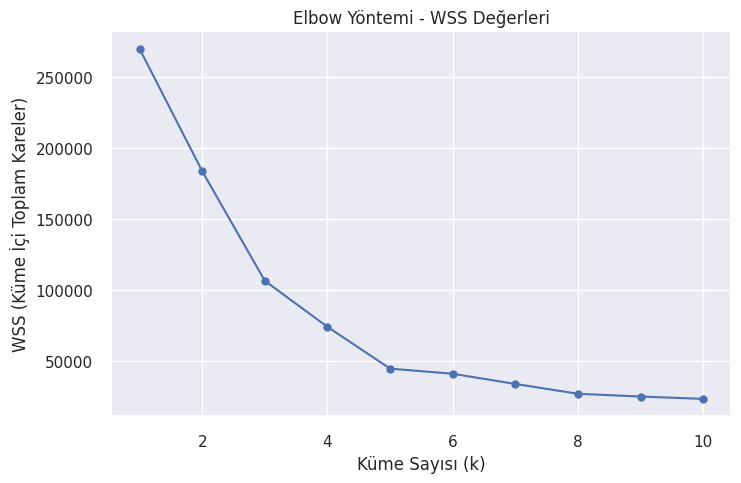

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 🔸 Kümeleme için kullanılacak veriyi seçiyoruz
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# 🔸 WSS değerlerini saklamak için boş liste
wss = []

# 🔸 1'den 10'a kadar k değerleri için WSS hesaplıyoruz
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

# 🔸 Elbow grafiğini çiziyoruz
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Yöntemi - WSS Değerleri')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('WSS (Küme İçi Toplam Kareler)')
plt.grid(True)
plt.show()

### Grafik Analiz
- Elbow grafiğinde, k = 5 noktasında WSS değerinin azalımı yavaşlamaktadır.
- Bu noktada "dirsek" şeklinde bir kırılma olduğu görülür.

✅  Bu durum, 5 kümenin segmentasyon için en uygun seçim olduğunu gösterir.



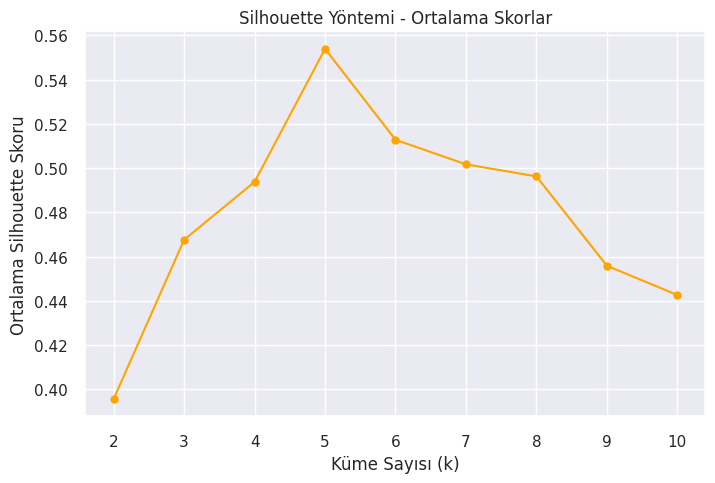

In [ ]:
from sklearn.metrics import silhouette_score

# 🔸 Silhouette skorlarını saklamak için boş liste
silhouette_scores = []

# 🔸 2'den 10'a kadar k değerleri için Silhouette skorlarını hesaplıyoruz
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# 🔸 Silhouette grafiğini çiziyoruz
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Yöntemi - Ortalama Skorlar')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Ortalama Silhouette Skoru')
plt.grid(True)
plt.show()


### Grafik Analiz
- **k = 5 **değerinde **silhouette skoru en yüksek seviyeye** ulaşmıştır (0.56 civarında). Bu, veri setinde 5 kümeye ayrıldığında müşteri segmentlerinin en net şekilde oluştuğunu göstermektedir.

- **k = 6, 7, 8’den** sonra skor düşmektedir. Bu da segmentasyonun gereksiz yere bölündüğünü, kümeler arası benzerliğin arttığını gösterir.

- **k = 2, 3** gibi düşük değerlerde **skor düşük** kalmış, yani veri yeterince iyi ayrılamamıştır.